In [1]:
## mmdeploy env

In [2]:
import json
import logging
from pathlib import Path
import sys

import matplotlib.pyplot as plt
from mmdet.apis import inference_detector, init_detector
from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.utils import adapt_mmdet_pipeline
import numpy as np
from PIL import Image

print(f"Environment: {sys.executable}")
logging.basicConfig(level=logging.INFO)

Environment: /home/jop9552/miniconda3/envs/mmdeploy_JP_v2/bin/python


In [3]:
# TODO: get mean bone lengths

# Setup

In [3]:
# Path to the pose estimators
# model_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-08-15-10-58-18/")
model_directory = Path(
    "/n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/20241030_v1/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-11-01-20-36-55"
)

# Path to the detector
detector_directory = Path(
    "/n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/xxx_20241030_v1/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-10-31-12-48-26"
)
val_dict_path = "/n/groups/datta/6cam_keypoint_networks/training_data/JP_CW_scale_annos/COCO_format/annotations/instances_val.json"

# where to save the viz'd images
n_imgs_to_show = 50
conf_threshold = 0.4  # confidence threshold for showing 'o' vs 'x' on the viz'd images
save_dir = Path(
    "/n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/20241030_v1/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-11-01-20-36-55/validation_imgs"
)
save_dir.mkdir(exist_ok=True)

pose_estimator_config = model_directory / "config.py"
detector_checkpoint = (
    detector_directory / "epoch_63.pth"
)  # choose a specific detector checkpoint
detector_config = detector_directory / "config.py"

In [4]:
!ls {model_directory}

20241101_203711        epoch_30.pth  epoch_80.pth
best_PCK_epoch_80.pth  epoch_40.pth  epoch_90.pth
config.py	       epoch_50.pth  last_checkpoint
epoch_10.pth	       epoch_60.pth  rtmpose-m_8xb64-210e_ap10k-256x256.py
epoch_20.pth	       epoch_70.pth  validation_imgs


In [5]:
config_loc = model_directory / "config.py"
checkpoint_loc = (
    config_loc.parent / "epoch_90.pth"
)  # choose a specific pose estimator checkpoint
pose_estimator_checkpoint = checkpoint_loc

# Plotting

## Plot loss and accuracy

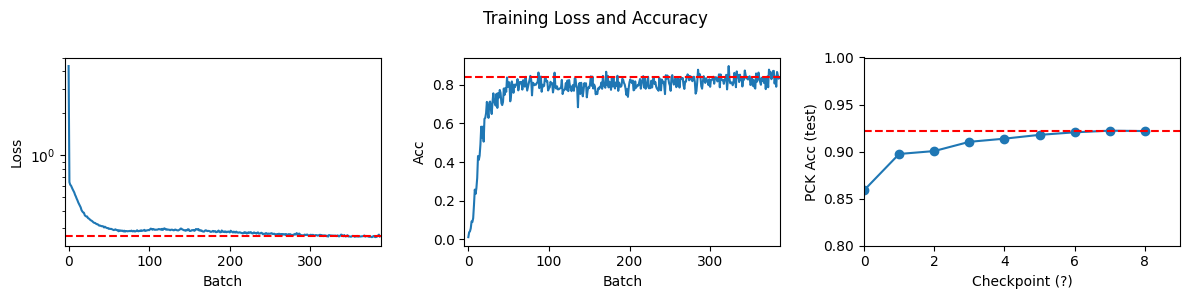

In [6]:
with open(list(model_directory.glob("*/*.log"))[0], "r") as file:
    log_info = file.read()
loss_lines = [i for i in log_info.split("\n") if " loss: " in i]
loss = [float(i.split("  loss: ")[1].split("  loss_kpt:")[0]) for i in loss_lines]
acc = [float(i.split("  acc_pose: ")[1]) for i in loss_lines]
# Epoch(val) [70][54/54]    PCK: 0.919028  data_time: 0.048835  time: 0.147817
val_lines = [i for i in log_info.split("\n") if ("Epoch(val)" in i) and ("PCK" in i)]
pck_acc = [float(i.split("  PCK: ")[1].split("  data_time:")[0]) for i in val_lines]

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
axs[0].plot(np.arange(len(loss)), loss)
axs[0].set_xlim([-5, len(loss)])
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Loss")
axs[0].set_yscale("log")
axs[0].axhline(y=loss[-1], color="r", linestyle="--")
axs[1].plot(np.arange(len(acc)), acc)
axs[1].set_xlim([-5, len(acc)])
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Acc")
axs[1].axhline(y=acc[-1], color="r", linestyle="--")

axs[2].plot(np.arange(len(pck_acc)), pck_acc, "-o")
axs[2].axhline(y=pck_acc[-1], color="r", linestyle="--")
axs[2].set_xlim([0, len(pck_acc)])
axs[2].set_ylim([0.8, 1])
axs[2].set_xlabel("Checkpoint (?)")
axs[2].set_ylabel("PCK Acc (test)")
fig.suptitle("Training Loss and Accuracy")
fig.tight_layout()

## Sample predictions

In [7]:
def coco_to_np_keypoints(coco_kps):
    return np.array(coco_kps).reshape(-1, 3)

def camera_from_filename(filename):
    if "top" in filename:
        return "top"
    elif "side" in filename:
        return "side"
    elif "bottom" in filename:
        return "bottom"
    
with open(val_dict_path, "r") as file:
    val_dict = json.load(file)

all_val_img_paths = {i["id"]: i["file_path"] for i in val_dict["images"]}
all_val_img_cameras = {i["id"]: camera_from_filename(i["file_name"]) for i in val_dict["images"]}
ground_truth_kps = {
    i["image_id"]: coco_to_np_keypoints(i["keypoints"]) for i in val_dict["annotations"]
}
all_img_ids = list(ground_truth_kps.keys())

In [8]:
ground_truth_kps[30]

array([[279, 886,   2],
       [277, 910,   2],
       [475, 980,   2],
       [326, 801,   2],
       [395, 816,   2],
       [  0,   0,   0],
       [445, 832,   2],
       [423, 894,   2],
       [393, 933,   2],
       [367, 923,   2],
       [390, 897,   2],
       [330, 911,   2],
       [359, 924,   2],
       [307, 862,   2],
       [340, 831,   2]])

In [9]:
pose_estimator_config = Path(pose_estimator_config)
pose_estimator_checkpoint = Path(pose_estimator_checkpoint)
detector_config = Path(detector_config)
detector_checkpoint = Path(detector_checkpoint)
pose_estimator = init_pose_estimator(
    pose_estimator_config.as_posix(),
    pose_estimator_checkpoint.as_posix(),
    device="cuda",
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=True))),
)

Loads checkpoint by local backend from path: /n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/20241030_v1/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-11-01-20-36-55/epoch_90.pth


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [8]:
detector = init_detector(
    detector_config.as_posix(), detector_checkpoint.as_posix(), device="cuda"
)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

Loads checkpoint by local backend from path: /n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/xxx_20241030_v1/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-10-31-12-48-26/epoch_63.pth


## Show 2d predictions, distinguishing high vs low conf detections

In [14]:
imgs_to_use = np.random.choice(all_img_ids, n_imgs_to_show)
for img_id in imgs_to_use:
    img_path = all_val_img_paths[img_id]
    frame = np.array(Image.open(img_path))
    det_result = inference_detector(detector, img_path)
    bboxes = det_result.pred_instances["bboxes"].cpu().numpy()
    mmpose_bbox = bboxes[0]  # xyxy, not xywh
    conf = det_result.pred_instances["scores"].cpu().numpy()
    predictions = inference_topdown(pose_estimator, img=frame, bboxes=bboxes)
    keypoint_estimates = predictions[0].pred_instances.keypoints[0]
    kpt_names = np.array(list(pose_estimator.dataset_meta["keypoint_id2name"].values()))
    kpt_confidences = predictions[0].pred_instances.keypoint_scores[0]
    kpt_colors = pose_estimator.dataset_meta["keypoint_colors"]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(frame)
    text_bbox = dict(boxstyle="square", fc=(0.8, 0.8, 0.8), alpha=0.5)
    for i, kpt in enumerate(keypoint_estimates):
        marker = "x" if kpt_confidences[i] < conf_threshold else "o"
        ax.scatter(
            kpt[0], kpt[1], marker=marker, s=300, color=kpt_colors[i] / 255, alpha=0.5
        )
        abbrev = (
            "".join([w[0] for w in kpt_names[i].split("_")])
            if "_" in kpt_names[i]
            else kpt_names[i][0]
        )
        # ax.text(kpt[0], kpt[1], abbrev, color='limegreen',bbox=text_bbox)
        ax.text(
            kpt[0],
            kpt[1],
            abbrev,
            color="k",
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax.set_xlim(mmpose_bbox[0], mmpose_bbox[2])
    ax.set_ylim(mmpose_bbox[3], mmpose_bbox[1])
    fig.suptitle(f"Image ID: {img_id}")
    fig.savefig(save_dir / f"{img_id}_conf_thresh_{conf_threshold}.png")
    plt.close(fig)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


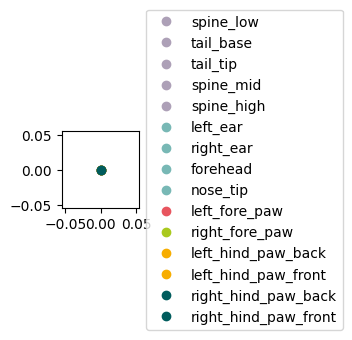

In [10]:
# make simple blank fig showing the color scheme
fig, ax = plt.subplots(figsize=(1, 1))
for kpt_name, kpt_color in zip(kpt_names, kpt_colors):
    ax.plot(0, 0, "o", color=kpt_color / 255, label=kpt_name)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [66]:
n_imgs_to_show = 200
default_conf_thresh = 0.4
conf_thresholds_by_camera = {
    "bottom": {
        "spine": 0.8,
        "ear": 0.8,
        "forehead": 0.8,
        "tail": default_conf_thresh,
        "nose_tip": default_conf_thresh,
        "hind_paw": default_conf_thresh,
        "fore_paw": default_conf_thresh,
    },
    "top": {
        "spine": default_conf_thresh,
        "ear": default_conf_thresh,
        "forehead": default_conf_thresh,
        "tail": default_conf_thresh,
        "nose_tip": default_conf_thresh,
        "hind_paw": 0.7,
        "fore_paw": 0.7,
    },        
    "side": {
        "spine": default_conf_thresh,
        "ear": default_conf_thresh,
        "forehead": default_conf_thresh,
        "tail": default_conf_thresh,
        "nose_tip": default_conf_thresh,
        "hind_paw": 0.65,
        "fore_paw": 0.65,
    },
}

imgs_to_use = np.random.choice(all_img_ids, n_imgs_to_show)
for img_id in imgs_to_use:
    img_path = all_val_img_paths[img_id]
    frame = np.array(Image.open(img_path))
    camera = all_val_img_cameras[img_id]
    det_result = inference_detector(detector, img_path)
    bboxes = det_result.pred_instances["bboxes"].cpu().numpy()
    mmpose_bbox = bboxes[0]  # xyxy, not xywh
    conf = det_result.pred_instances["scores"].cpu().numpy()
    predictions = inference_topdown(pose_estimator, img=frame, bboxes=bboxes)
    keypoint_estimates = predictions[0].pred_instances.keypoints[0]
    kpt_names = np.array(list(pose_estimator.dataset_meta["keypoint_id2name"].values()))
    kpt_confidences = predictions[0].pred_instances.keypoint_scores[0]
    kpt_colors = pose_estimator.dataset_meta["keypoint_colors"]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(frame)
    text_bbox = dict(boxstyle="square", fc=(0.8, 0.8, 0.8), alpha=0.5)
    for i, kpt in enumerate(keypoint_estimates):
        conf_dict = conf_thresholds_by_camera[camera]
        this_conf_thresh = [conf_dict[k] for k in conf_dict.keys() if k in kpt_names[i]][0]
        marker = "x" if kpt_confidences[i] < this_conf_thresh else "o"
        ax.scatter(
            kpt[0], kpt[1], marker=marker, s=300, color=kpt_colors[i] / 255, alpha=0.5
        )
        abbrev = (
            "".join([w[0] for w in kpt_names[i].split("_")])
            if "_" in kpt_names[i]
            else kpt_names[i][0]
        )
        # ax.text(kpt[0], kpt[1], abbrev, color='limegreen',bbox=text_bbox)
        ax.text(
            kpt[0],
            kpt[1],
            abbrev,
            color="k",
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax.set_xlim(mmpose_bbox[0], mmpose_bbox[2])
    ax.set_ylim(mmpose_bbox[3], mmpose_bbox[1])
    fig.suptitle(f"Image ID: {img_id}")
    # print(list(zip(kpt_confidences, kpt_names)))
    fig.savefig(save_dir / f"{img_id}_custom_conf_thresh_by_cam.png")
    plt.close(fig)
    

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


## Show 2D predictions w PCK accuracy

In [11]:
# from mmpose.evaluation import keypoint_pck_accuracy
# imgs_to_use = np.random.choice(all_img_ids, 10)
# for img_id in imgs_to_use:
#     img_path = all_val_img_paths[img_id]
#     frame = np.array(Image.open(img_path))
#     det_result = inference_detector(detector, img_path)
#     bboxes = det_result.pred_instances["bboxes"].cpu().numpy()
#     mmpose_bbox = bboxes[0]  # xyxy, not xywh
#     bbox_size_ = np.max(mmpose_bbox[2:] - mmpose_bbox[:2])
#     bbox_norm = np.array([bbox_size_, bbox_size_]).reshape(-1, 2)
#     conf = det_result.pred_instances["scores"].cpu().numpy()
#     predictions = inference_topdown(pose_estimator, img=frame, bboxes=bboxes)
#     keypoint_estimates = predictions[0].pred_instances.keypoints[0]
#     kpt_names = np.array(list(pose_estimator.dataset_meta['keypoint_id2name'].values()))
#     kpt_confidences = predictions[0].pred_instances.keypoint_scores[0]
#     kpt_colors = pose_estimator.dataset_meta['keypoint_colors']

#     # Get PCK accuracy
#     gt = ground_truth_kps[img_id]  # n_kpts x 3 (x, y, vis)
#     acc, avg_acc, n_valid = keypoint_pck_accuracy(  # have to add an extra dim for "instance"
#         keypoint_estimates[None,...],
#         gt[None, :, :2],
#         gt[None, :, 2] > 0,
#         thr=0.05,
#         norm_factor=bbox_norm,  # already 1x2
#     )

#     fig, ax = plt.subplots(figsize=(10,10))
#     ax.imshow(frame)
#     for i, kpt in enumerate(keypoint_estimates):
#         abbrev = ''.join([w[0] for w in kpt_names[i].split('_')]) if '_' in kpt_names[i] else kpt_names[i][0]

#         # if keypoint not in ground truth to begin with, dont show
#         if acc[i] == -1:
#             continue

#         # if keypoint is wrong, show with an X and show gt with a triangle.
#         if acc[i] != 1:
#             ax.scatter(kpt[0], kpt[1], marker='x', s=300, color=kpt_colors[i]/255, alpha=0.5)
#             ax.scatter(gt[i, 0], gt[i, 1], marker='^', s=300, color=kpt_colors[i]/255, alpha=0.5)
#             ax.text(gt[i, 0], gt[i, 1], abbrev, color='w', fontsize=10, horizontalalignment="center", verticalalignment="center")
#         else:
#             ax.scatter(kpt[0], kpt[1], marker='o', s=300, color=kpt_colors[i]/255, alpha=0.5)
#         ax.text(kpt[0], kpt[1], abbrev, color='k', fontsize=10, horizontalalignment="center", verticalalignment="center")
#     ax.set_xlim(mmpose_bbox[0], mmpose_bbox[2])
#     ax.set_ylim(mmpose_bbox[3], mmpose_bbox[1])
